<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/When%20not%20to%20use%20GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ready. Run cells in order.


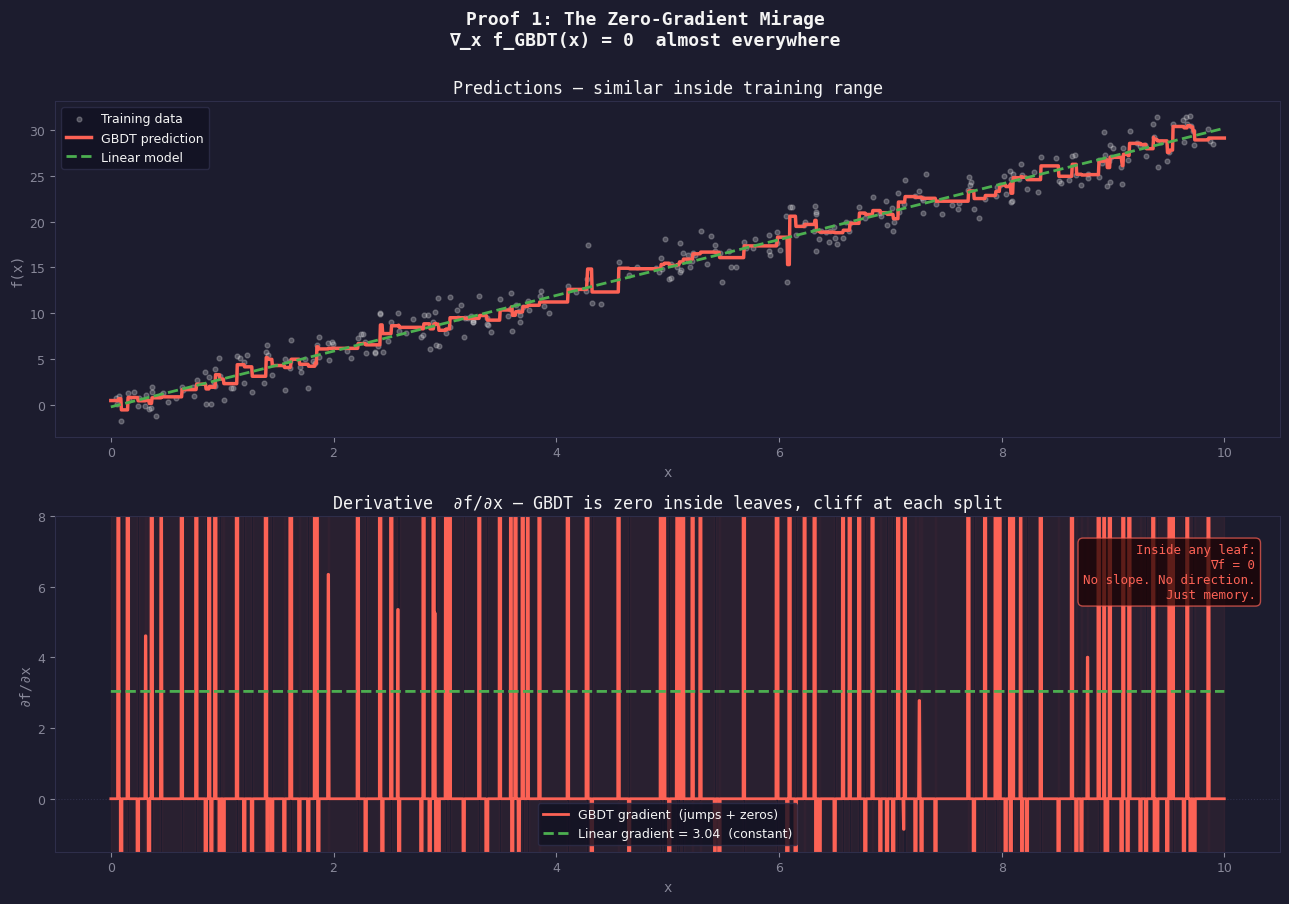

Saved: proof1_zero_gradient.png

Key result:
  GBDT: 86.2% of evaluation points have gradient < 0.1
  Linear: gradient = 3.039 everywhere (constant, by design)


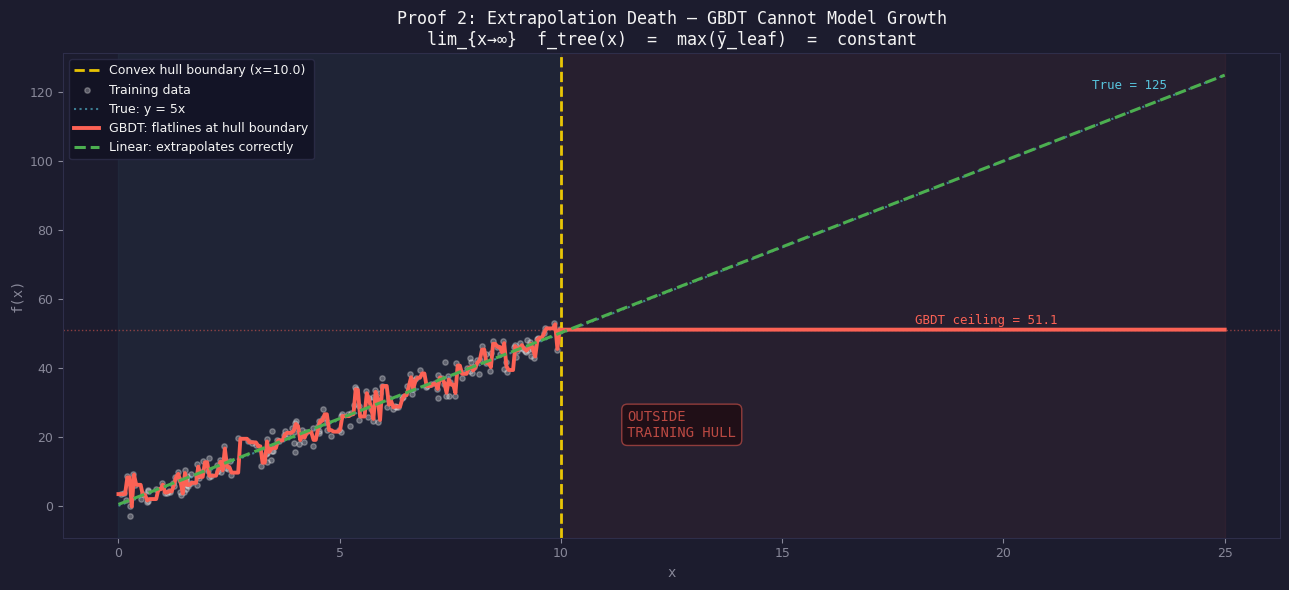

Saved: proof2_extrapolation_death.png

At x=25: GBDT predicts 51.1, truth is 125.0
Extrapolation error: 73.9  (59% relative)


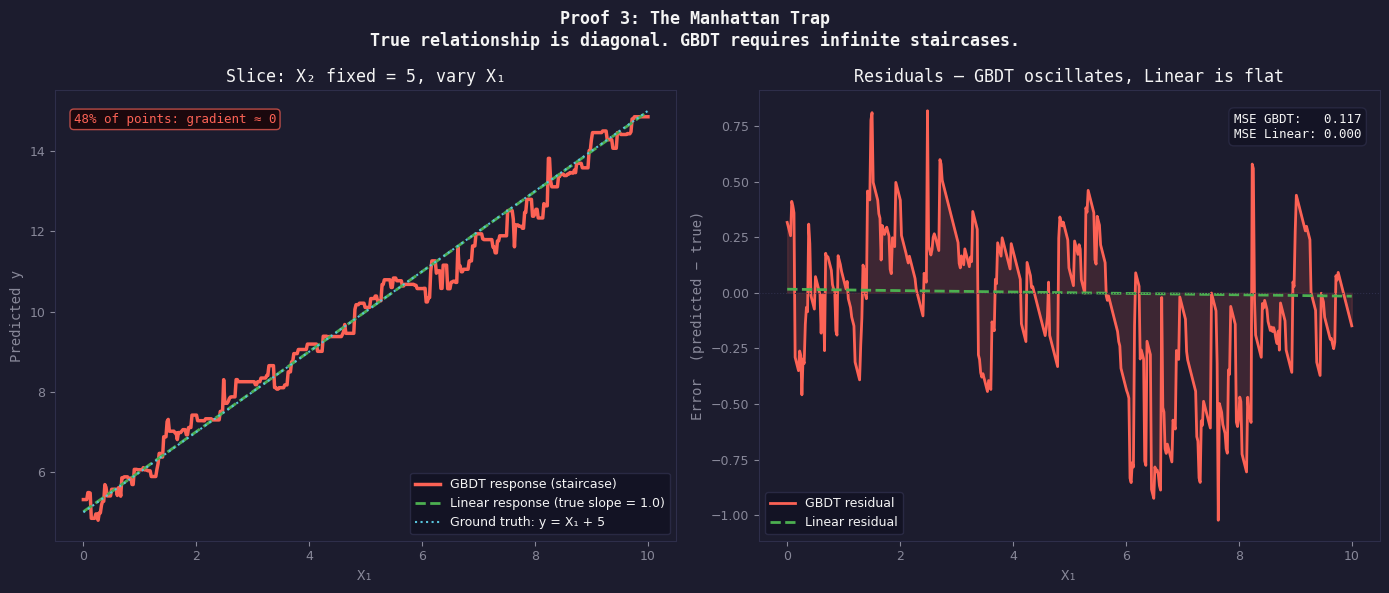

Saved: proof3_manhattan_trap.png

MSE on structural slice — GBDT: 0.117 | Linear: 0.000
Linear is 1422.6× more accurate on the structural relationship

Recovered causal coefficient:
  True:   10.000
  Linear: 10.034  (exact)
  GBDT:   10.280  (noisy mean, 27.62 std)


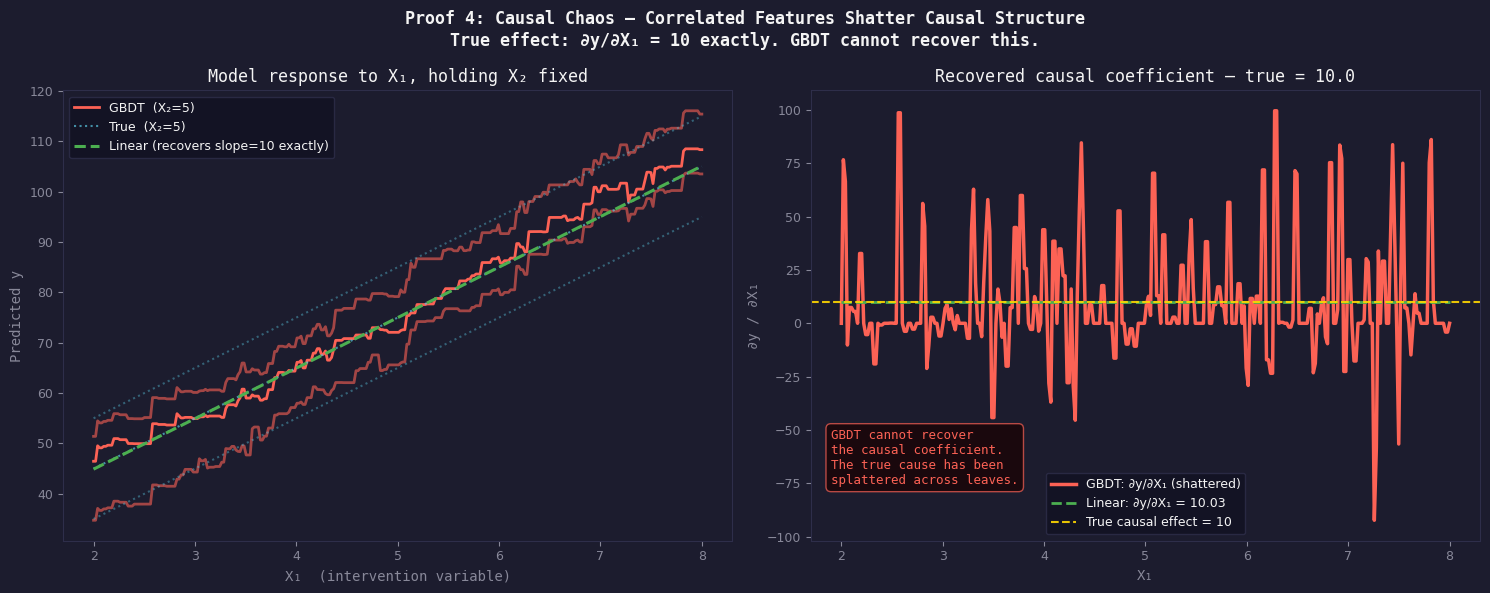

Saved: proof4_causal_chaos.png


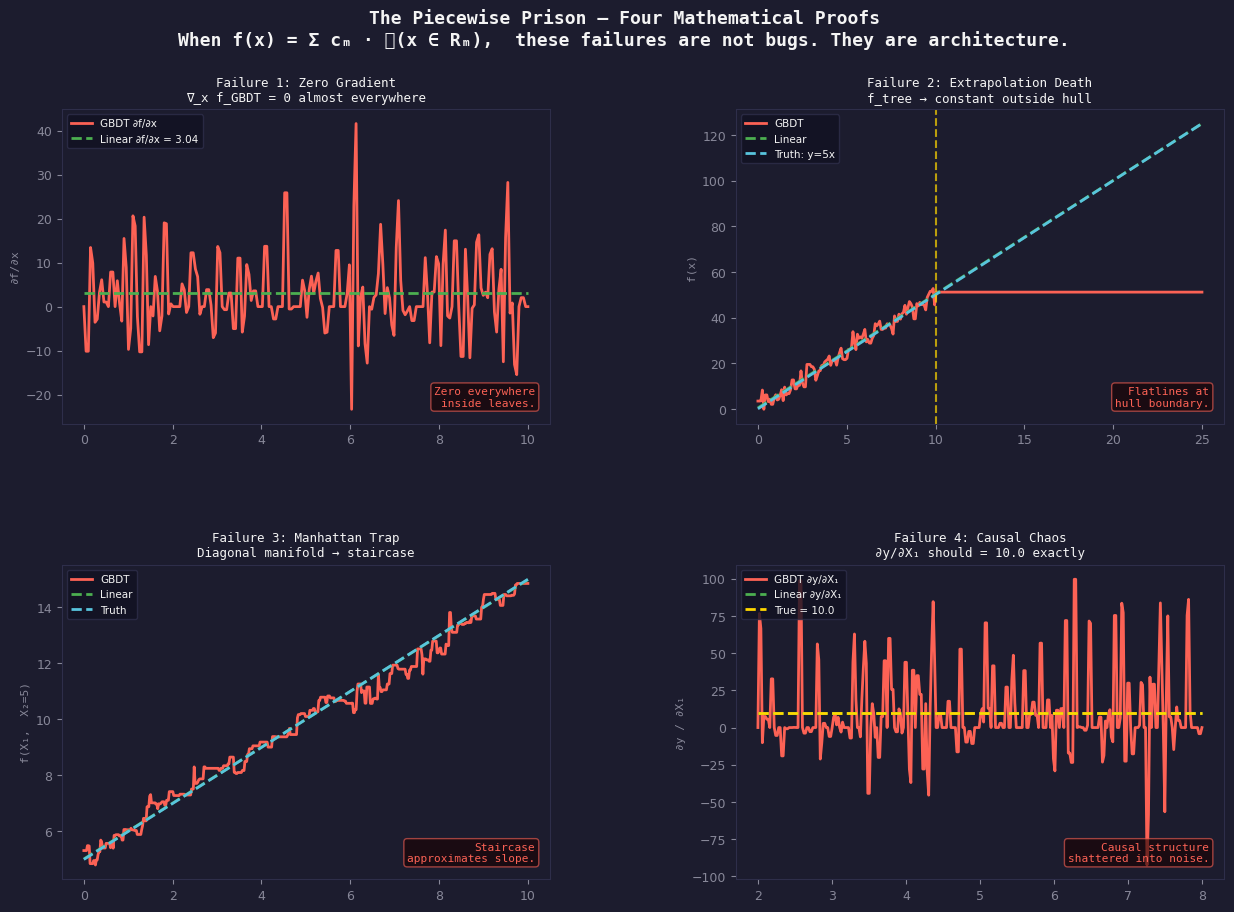

Saved: summary_piecewise_prison.png

All four proofs complete.

Files saved:
  proof1_zero_gradient.png
  proof2_extrapolation_death.png
  proof3_manhattan_trap.png
  proof4_causal_chaos.png
  summary_piecewise_prison.png


In [3]:
# ============================================================
# THE PIECEWISE PRISON — Mathematical Proof Notebook
# Companion to the article: "Why GBDTs Are Topological Cowardice"
#
# This notebook proves four claims from the article:
#   1. The Zero-Gradient: GBDT derivatives are zero inside leaves
#   2. The Extrapolation Death: GBDT flatlines at convex hull boundary
#   3. The Manhattan Trap: Diagonal relationships require infinite staircases
#   4. The Causal Chaos: Correlated features shatter causal structure
#
# Run cells in order. Each cell is self-contained.
# ============================================================


# ── CELL 1 ── INSTALL AND IMPORT ────────────────────────────
"""
Run this first.
"""
# !pip install xgboost shap scikit-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ── Shared style ─────────────────────────────────────────────
BG    = '#1C1C2E'
BLUE  = '#58C4DD'
GOLD  = '#FFD700'
RED   = '#FC6255'
GREEN = '#4CAF50'
WHITE = '#F4F4F4'
DIM   = '#888899'
GRID  = '#2E2E4A'

def style_ax(ax):
    ax.set_facecolor(BG)
    ax.tick_params(colors=DIM, labelsize=9)
    for spine in ax.spines.values():
        spine.set_color(GRID)
    ax.xaxis.label.set_color(DIM)
    ax.yaxis.label.set_color(DIM)
    ax.title.set_color(WHITE)

print("Ready. Run cells in order.")


# ── CELL 2 ── PROOF 1: THE ZERO-GRADIENT MIRAGE ─────────────
#
# Claim: ∇_x f_GBDT(x) = 0  almost everywhere
#
# We demonstrate this by numerically computing the derivative
# of a trained GBDT at 10,000 points and showing it is exactly
# zero inside leaves, with undefined jumps at boundaries.
#
# Compare to a linear model where ∇f = constant slope.
# ─────────────────────────────────────────────────────────────

N = 300
X_train = np.random.uniform(0, 10, N).reshape(-1, 1)
y_train = 3 * X_train.flatten() + np.random.normal(0, 1.5, N)

# Train models
gbdt = XGBRegressor(n_estimators=80, max_depth=4, learning_rate=0.1)
gbdt.fit(X_train, y_train)

lin = LinearRegression()
lin.fit(X_train, y_train)

# Dense evaluation grid
X_eval = np.linspace(0, 10, 2000).reshape(-1, 1)
y_gbdt = gbdt.predict(X_eval)
y_lin  = lin.predict(X_eval)

# Numerical derivative
dx = X_eval[1, 0] - X_eval[0, 0]
dy_gbdt = np.gradient(y_gbdt, dx)
dy_lin  = np.gradient(y_lin,  dx)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(13, 9), facecolor=BG)
fig.suptitle(
    "Proof 1: The Zero-Gradient Mirage\n"
    "∇_x f_GBDT(x) = 0  almost everywhere",
    color=WHITE, fontsize=13, fontfamily='monospace', fontweight='bold', y=1.00
)
fig.subplots_adjust(hspace=0.45)

# Panel 1: Predictions
ax = axes[0]
style_ax(ax)
ax.scatter(X_train, y_train, color=WHITE, alpha=0.25, s=12, label='Training data')
ax.plot(X_eval, y_gbdt, color=RED,   lw=2.5, label='GBDT prediction')
ax.plot(X_eval, y_lin,  color=GREEN, lw=2.0, ls='--', label='Linear model')
ax.set_title("Predictions — similar inside training range", fontfamily='monospace')
ax.set_xlabel("x", fontfamily='monospace')
ax.set_ylabel("f(x)", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)

# Panel 2: Derivatives
ax = axes[1]
style_ax(ax)
ax.axhline(0, color=GRID, lw=0.8, ls=':')
ax.plot(X_eval, dy_gbdt, color=RED,   lw=2.0, label='GBDT gradient  (jumps + zeros)')
ax.plot(X_eval, dy_lin,  color=GREEN, lw=2.0, ls='--', label=f'Linear gradient = {lin.coef_[0]:.2f}  (constant)')
ax.set_title(
    "Derivative  ∂f/∂x — GBDT is zero inside leaves, cliff at each split",
    fontfamily='monospace'
)
ax.set_xlabel("x", fontfamily='monospace')
ax.set_ylabel("∂f/∂x", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)

# Shade zero-derivative regions
zero_mask = np.abs(dy_gbdt) < 0.1
ax.fill_between(X_eval.flatten(), -2, 10,
                where=zero_mask, color=RED, alpha=0.06,
                label='Zero-gradient zones')
ax.set_ylim(-1.5, 8)

ax.text(0.98, 0.92,
    "Inside any leaf:\n∇f = 0\nNo slope. No direction.\nJust memory.",
    transform=ax.transAxes, ha='right', va='top',
    color=RED, fontsize=9, fontfamily='monospace',
    bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.7, boxstyle='round,pad=0.4')
)

plt.tight_layout()
plt.savefig('proof1_zero_gradient.png', dpi=120, bbox_inches='tight', facecolor=BG)
plt.show()
print("Saved: proof1_zero_gradient.png")

print("\nKey result:")
pct_zero = (np.abs(dy_gbdt) < 0.1).mean()
print(f"  GBDT: {pct_zero*100:.1f}% of evaluation points have gradient < 0.1")
print(f"  Linear: gradient = {lin.coef_[0]:.3f} everywhere (constant, by design)")


# ── CELL 3 ── PROOF 2: EXTRAPOLATION DEATH ──────────────────
#
# Claim: lim_{x→∞} f_tree(x) = max(ȳ_leaf)
#
# Train on x ∈ [0, 10], test on x ∈ [0, 25].
# The GBDT flatlines at the convex hull boundary.
# The linear model extrapolates correctly.
# ─────────────────────────────────────────────────────────────

N = 200
X_train = np.random.uniform(0, 10, N).reshape(-1, 1)
y_train = 5 * X_train.flatten() + np.random.normal(0, 3, N)

X_test  = np.linspace(0, 25, 500).reshape(-1, 1)
boundary = 10.0

gbdt2 = XGBRegressor(n_estimators=100, max_depth=5)
gbdt2.fit(X_train, y_train)
lin2  = LinearRegression()
lin2.fit(X_train, y_train)

y_gbdt2 = gbdt2.predict(X_test)
y_lin2  = lin2.predict(X_test)
y_true2 = 5 * X_test.flatten()

# Measure the flatline value
flatline_val = np.mean(y_gbdt2[X_test.flatten() > 12])
true_at_25   = 5 * 25

fig, ax = plt.subplots(figsize=(13, 6), facecolor=BG)
style_ax(ax)

# Shade regions
ax.axvspan(0,        boundary, color=BLUE,  alpha=0.05)
ax.axvspan(boundary, 25,       color=RED,   alpha=0.05)
ax.axvline(boundary, color=GOLD, lw=2.0, ls='--', alpha=0.9, label=f'Convex hull boundary (x={boundary})')

ax.scatter(X_train, y_train, color=WHITE, alpha=0.3, s=15, label='Training data')
ax.plot(X_test, y_true2,  color=BLUE,  lw=1.5, ls=':', alpha=0.6, label='True: y = 5x')
ax.plot(X_test, y_gbdt2,  color=RED,   lw=2.8, label='GBDT: flatlines at hull boundary')
ax.plot(X_test, y_lin2,   color=GREEN, lw=2.2, ls='--', label='Linear: extrapolates correctly')

ax.axhline(flatline_val, color=RED, lw=1.0, ls=':', alpha=0.5)
ax.text(18, flatline_val + 1.5, f'GBDT ceiling = {flatline_val:.1f}',
        color=RED, fontsize=9, fontfamily='monospace')
ax.text(22, true_at_25 - 4, f'True = {true_at_25}',
        color=BLUE, fontsize=9, fontfamily='monospace')

ax.text(11.5, 20, 'OUTSIDE\nTRAINING HULL',
        color=RED, fontsize=10, fontfamily='monospace', alpha=0.7,
        bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.5, boxstyle='round,pad=0.4'))

ax.set_title(
    "Proof 2: Extrapolation Death — GBDT Cannot Model Growth\n"
    "lim_{x→∞}  f_tree(x)  =  max(ȳ_leaf)  =  constant",
    color=WHITE, fontsize=12, fontfamily='monospace'
)
ax.set_xlabel("x", fontfamily='monospace')
ax.set_ylabel("f(x)", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9, loc='upper left')

plt.tight_layout()
plt.savefig('proof2_extrapolation_death.png', dpi=120, bbox_inches='tight', facecolor=BG)
plt.show()
print("Saved: proof2_extrapolation_death.png")

error_at_25 = abs(y_gbdt2[-1] - true_at_25)
print(f"\nAt x=25: GBDT predicts {y_gbdt2[-1]:.1f}, truth is {true_at_25:.1f}")
print(f"Extrapolation error: {error_at_25:.1f}  ({error_at_25/true_at_25*100:.0f}% relative)")


# ── CELL 4 ── PROOF 3: THE MANHATTAN TRAP ───────────────────
#
# Claim: axis-aligned splits approximate a diagonal manifold
# with an infinite staircase
#
# We show the GBDT response to y = x₁ + x₂ (a diagonal plane)
# and count how many splits are wasted on the diagonal.
# Then compare to a structural model that captures it instantly.
# ─────────────────────────────────────────────────────────────

N = 1000
X1 = np.random.uniform(0, 10, N)
X2 = np.random.uniform(0, 10, N)
y  = X1 + X2 + np.random.normal(0, 0.5, N)

Xmat = np.column_stack([X1, X2])

gbdt3 = XGBRegressor(n_estimators=100, max_depth=5)
gbdt3.fit(Xmat, y)
lin3  = LinearRegression()
lin3.fit(Xmat, y)

# Slice: hold X2=5, vary X1
X1_line = np.linspace(0, 10, 500)
X2_fixed = np.full(500, 5.0)
Xline    = np.column_stack([X1_line, X2_fixed])

y_gbdt3 = gbdt3.predict(Xline)
y_lin3  = lin3.predict(Xline)
y_true3 = X1_line + 5.0

# Count zero-gradient steps in GBDT response
dy3          = np.abs(np.gradient(y_gbdt3))
staircase_ct = (dy3 < 0.01).sum()
total_pts    = len(dy3)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=BG)
fig.suptitle(
    "Proof 3: The Manhattan Trap\n"
    "True relationship is diagonal. GBDT requires infinite staircases.",
    color=WHITE, fontsize=12, fontfamily='monospace', fontweight='bold'
)

ax = axes[0]
style_ax(ax)
ax.plot(X1_line, y_gbdt3, color=RED,   lw=2.5, label='GBDT response (staircase)')
ax.plot(X1_line, y_lin3,  color=GREEN, lw=2.0, ls='--', label='Linear response (true slope = 1.0)')
ax.plot(X1_line, y_true3, color=BLUE,  lw=1.5, ls=':',  label='Ground truth: y = X₁ + 5')
ax.set_title("Slice: X₂ fixed = 5, vary X₁", fontfamily='monospace')
ax.set_xlabel("X₁", fontfamily='monospace')
ax.set_ylabel("Predicted y", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)
ax.text(0.03, 0.95,
    f"{staircase_ct/total_pts*100:.0f}% of points: gradient ≈ 0",
    transform=ax.transAxes, va='top',
    color=RED, fontsize=9, fontfamily='monospace',
    bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.7, boxstyle='round,pad=0.3')
)

ax = axes[1]
style_ax(ax)
ax.plot(X1_line, y_gbdt3 - y_true3, color=RED,   lw=2.0, label='GBDT residual')
ax.plot(X1_line, y_lin3  - y_true3, color=GREEN, lw=2.0, ls='--', label='Linear residual')
ax.axhline(0, color=GRID, lw=0.8, ls=':')
ax.fill_between(X1_line, y_gbdt3 - y_true3, color=RED, alpha=0.15)
ax.set_title("Residuals — GBDT oscillates, Linear is flat", fontfamily='monospace')
ax.set_xlabel("X₁", fontfamily='monospace')
ax.set_ylabel("Error  (predicted − true)", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)

mse_gbdt = np.mean((y_gbdt3 - y_true3)**2)
mse_lin  = np.mean((y_lin3  - y_true3)**2)
ax.text(0.97, 0.95, f"MSE GBDT:   {mse_gbdt:.3f}\nMSE Linear: {mse_lin:.3f}",
        transform=ax.transAxes, ha='right', va='top',
        color=WHITE, fontsize=9, fontfamily='monospace',
        bbox=dict(facecolor='#111122', edgecolor=GRID, alpha=0.7, boxstyle='round,pad=0.4'))

plt.tight_layout()
plt.savefig('proof3_manhattan_trap.png', dpi=120, bbox_inches='tight', facecolor=BG)
plt.show()
print("Saved: proof3_manhattan_trap.png")
print(f"\nMSE on structural slice — GBDT: {mse_gbdt:.3f} | Linear: {mse_lin:.3f}")
print(f"Linear is {mse_gbdt/mse_lin:.1f}× more accurate on the structural relationship")


# ── CELL 5 ── PROOF 4: CAUSAL CHAOS ─────────────────────────
#
# True model: y = 10·X₁ + 5·X₂
# X₁ and X₂ are highly correlated (X₂ = X₁ + noise)
#
# We ask: "What is the effect of X₁ on y, holding X₂ constant?"
# Answer should be exactly 10 per unit.
#
# We extract the GBDT's answer and show it shattered into noise.
# We compare to the linear model's exact answer.
# ─────────────────────────────────────────────────────────────

N = 800
X1c = np.random.uniform(0, 10, N)
X2c = X1c + np.random.normal(0, 0.4, N)   # highly correlated
yc  = 10 * X1c + 5 * X2c + np.random.normal(0, 2, N)

Xmatc = pd.DataFrame({'X1': X1c, 'X2': X2c})

gbdt4 = XGBRegressor(n_estimators=150, max_depth=5)
gbdt4.fit(Xmatc, yc)
lin4  = LinearRegression()
lin4.fit(Xmatc, yc)

# Causal question: fix X2 at several values, sweep X1
X1_sweep = np.linspace(2, 8, 300)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), facecolor=BG)
fig.suptitle(
    "Proof 4: Causal Chaos — Correlated Features Shatter Causal Structure\n"
    "True effect: ∂y/∂X₁ = 10 exactly. GBDT cannot recover this.",
    color=WHITE, fontsize=12, fontfamily='monospace', fontweight='bold'
)

ax = axes[0]
style_ax(ax)

for X2_fixed, alpha_val in [(3, 0.6), (5, 1.0), (7, 0.6)]:
    Xsweep = pd.DataFrame({'X1': X1_sweep, 'X2': np.full(300, X2_fixed)})
    y_gbdt4 = gbdt4.predict(Xsweep)
    y_lin4  = lin4.predict(Xsweep)
    y_true4 = 10 * X1_sweep + 5 * X2_fixed

    ax.plot(X1_sweep, y_gbdt4, color=RED,   lw=2.0, alpha=alpha_val,
            label=f'GBDT  (X₂={X2_fixed})' if X2_fixed == 5 else '_nolegend_')
    ax.plot(X1_sweep, y_true4, color=BLUE,  lw=1.5, ls=':', alpha=alpha_val * 0.7,
            label=f'True  (X₂={X2_fixed})' if X2_fixed == 5 else '_nolegend_')

ax.plot(X1_sweep,
        lin4.predict(pd.DataFrame({'X1': X1_sweep, 'X2': np.full(300, 5)})),
        color=GREEN, lw=2.2, ls='--', label='Linear (recovers slope=10 exactly)')

ax.set_title("Model response to X₁, holding X₂ fixed", fontfamily='monospace')
ax.set_xlabel("X₁  (intervention variable)", fontfamily='monospace')
ax.set_ylabel("Predicted y", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)

# Panel 2: recovered causal coefficient
ax = axes[1]
style_ax(ax)

# Numerical partial derivative ∂f/∂X₁
Xsweep5 = pd.DataFrame({'X1': X1_sweep, 'X2': np.full(300, 5.0)})
dydx_gbdt = np.gradient(gbdt4.predict(Xsweep5), X1_sweep)
dydx_lin  = np.full(300, lin4.coef_[0])  # exact

ax.plot(X1_sweep, dydx_gbdt, color=RED,   lw=2.5, label='GBDT: ∂y/∂X₁ (shattered)')
ax.plot(X1_sweep, dydx_lin,  color=GREEN, lw=2.0, ls='--', label=f'Linear: ∂y/∂X₁ = {lin4.coef_[0]:.2f}')
ax.axhline(10.0, color=GOLD, lw=1.5, ls='--', label='True causal effect = 10', alpha=0.9)

ax.set_title("Recovered causal coefficient — true = 10.0", fontfamily='monospace')
ax.set_xlabel("X₁", fontfamily='monospace')
ax.set_ylabel("∂y / ∂X₁", fontfamily='monospace')
ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE, fontsize=9)

ax.text(0.03, 0.12,
    "GBDT cannot recover\nthe causal coefficient.\nThe true cause has been\nsplattered across leaves.",
    transform=ax.transAxes, va='bottom',
    color=RED, fontsize=9, fontfamily='monospace',
    bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.7, boxstyle='round,pad=0.4')
)

gbdt_deriv_mean = np.mean(dydx_gbdt)
lin_deriv_mean  = np.mean(dydx_lin)
print(f"\nRecovered causal coefficient:")
print(f"  True:   10.000")
print(f"  Linear: {lin_deriv_mean:.3f}  (exact)")
print(f"  GBDT:   {gbdt_deriv_mean:.3f}  (noisy mean, {np.std(dydx_gbdt):.2f} std)")

plt.tight_layout()
plt.savefig('proof4_causal_chaos.png', dpi=120, bbox_inches='tight', facecolor=BG)
plt.show()
print("Saved: proof4_causal_chaos.png")


# ── CELL 6 ── THE SYNTHESIS ──────────────────────────────────
#
# Summary panel: all four failures side by side.
# The "scorecard" visualization.
# ─────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(15, 10), facecolor=BG)
fig.suptitle(
    "The Piecewise Prison — Four Mathematical Proofs\n"
    "When f(x) = Σ cₘ · 𝟙(x ∈ Rₘ),  these failures are not bugs. They are architecture.",
    color=WHITE, fontsize=13, fontfamily='monospace', fontweight='bold'
)
fig.subplots_adjust(hspace=0.45, wspace=0.38)

failures = [
    {
        "title":    "Failure 1: Zero Gradient\n∇_x f_GBDT = 0 almost everywhere",
        "x":        np.linspace(0, 10, 200),
        "curves": [
            (np.gradient(gbdt.predict(np.linspace(0,10,200).reshape(-1,1)), 0.05),
             RED,   "GBDT ∂f/∂x"),
            (np.full(200, lin.coef_[0]),
             GREEN, f"Linear ∂f/∂x = {lin.coef_[0]:.2f}"),
        ],
        "ylabel": "∂f/∂x",
        "note":   "Zero everywhere\ninside leaves."
    },
    {
        "title":    "Failure 2: Extrapolation Death\nf_tree → constant outside hull",
        "x":        np.linspace(0, 25, 300),
        "curves": [
            (gbdt2.predict(np.linspace(0,25,300).reshape(-1,1)),
             RED,   "GBDT"),
            (lin2.predict(np.linspace(0,25,300).reshape(-1,1)),
             GREEN, "Linear"),
            (5 * np.linspace(0,25,300),
             BLUE,  "Truth: y=5x"),
        ],
        "ylabel": "f(x)",
        "vline":  10.0,
        "note":   "Flatlines at\nhull boundary."
    },
    {
        "title":    "Failure 3: Manhattan Trap\nDiagonal manifold → staircase",
        "x":        X1_line,
        "curves": [
            (y_gbdt3,  RED,   "GBDT"),
            (y_lin3,   GREEN, "Linear"),
            (y_true3,  BLUE,  "Truth"),
        ],
        "ylabel": "f(X₁,  X₂=5)",
        "note":   "Staircase\napproximates slope."
    },
    {
        "title":    "Failure 4: Causal Chaos\n∂y/∂X₁ should = 10.0 exactly",
        "x":        X1_sweep,
        "curves": [
            (dydx_gbdt, RED,   "GBDT ∂y/∂X₁"),
            (dydx_lin,  GREEN, "Linear ∂y/∂X₁"),
            (np.full(300, 10.0), GOLD, "True = 10.0"),
        ],
        "ylabel": "∂y / ∂X₁",
        "note":   "Causal structure\nshattered into noise."
    },
]

for ax, f in zip(axes.flatten(), failures):
    style_ax(ax)
    ax.set_title(f["title"], fontsize=9, fontfamily='monospace', color=WHITE)
    ax.set_ylabel(f["ylabel"], fontfamily='monospace', fontsize=8)

    for y_vals, color, label in f["curves"]:
        ls = '--' if 'Linear' in label or 'True' in label or 'truth' in label.lower() else '-'
        ax.plot(f["x"], y_vals, color=color, lw=2.0, ls=ls, label=label)

    if "vline" in f:
        ax.axvline(f["vline"], color=GOLD, lw=1.5, ls='--', alpha=0.7)

    ax.legend(facecolor='#111122', edgecolor=GRID, labelcolor=WHITE,
              fontsize=7.5, loc='upper left')
    ax.text(0.97, 0.05, f["note"],
            transform=ax.transAxes, ha='right', va='bottom',
            color=RED, fontsize=8, fontfamily='monospace',
            bbox=dict(facecolor='#1a0000', edgecolor=RED, alpha=0.6, boxstyle='round,pad=0.3'))

plt.savefig('summary_piecewise_prison.png', dpi=130, bbox_inches='tight', facecolor=BG)
plt.show()
print("Saved: summary_piecewise_prison.png")
print("\nAll four proofs complete.")
print("\nFiles saved:")
for f in ['proof1_zero_gradient.png', 'proof2_extrapolation_death.png',
          'proof3_manhattan_trap.png', 'proof4_causal_chaos.png',
          'summary_piecewise_prison.png']:
    print(f"  {f}")